In [ ]:
import math
import brian2 as b2
from brian2 import * 
from brian2tools import *
from brian2 import collect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurodynex3 as nd3
from functions_spectrum import *
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import random
%matplotlib inline
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, spike_tools
from neurodynex3.tools import plot_tools, input_factory
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
import tqdm
import pickle
import logging
logging.getLogger(b2.__name__).setLevel(logging.ERROR)
logging.getLogger(nd3.__name__).setLevel(logging.ERROR)

In [22]:
rates_input_const = [4500]*4000 + [6500]*1000 

In [ ]:
start_scope()
C_E = 0.25 *nF
C_I = 0.2 *nF
N_e = 4000
N_i = 1000
gL_E = 25 * nS
gL_I = 20 * nS

eL_E = -65.0 * mV
eL_I = -67.0 * mV

# refractory
refractory_E = 1.3 * ms
refractory_I = 1.3 * ms

# thresholds and exponential behavior
deltaT = 3.48 * mV
VT = -59.9 * mV
V_thr = -30 * mV
V_r = -68.0 * mV

# synaptic reversal potentials 
esynE = 0.0 * mV
esynI = -75.0 * mV  

# rise times
rise_AMPA = 0.5 * ms
rise_GABA = 0.5 * ms

# decay times
decay_AMPA = 2.0 * ms
decay_GABA = 5.0 * ms

# conductances 
gsynE_E = 4.5 * 1.3 * nS
gsynI_E = 6 * 8.75 * nS
gsynE_I = 2.3 * 0.93 * nS
gsynI_I = 3.3 * 6.2 * nS

# latencies
latency_AMPA = 1.5 *ms
latency_GABA = 0.5 *ms

# psx - postsynaptic constant x - added upon presyn. spike
psx_AMPA = 1.0
psx_GABA = 1.0
psx_AMPA_ext = 1.5

alpha = 1.0 / ms

#STDP
dApre = -0.2
dApost = 0.2
taupre = 20 *ms 
taupost = 20 *ms 

In [10]:
# from attractors_and_oscillation/differential_equations/eif_equations.py (https://github.com/bnra/attractors_and_oscillation)

"""
Equations for the exponential integrate-and-fire neuron with AMPA and GABA type synaptic input based on

- Nicolas Fourcaud-Trocmé, David Hansel, Carl Van Vreeswijk, and Nicolas Brunel. How spike generation mechanisms determine the neuronal response to fluctuating inputs. Journal of neuroscience, 23(37):11628–11640, 2003.

- Nicolas Brunel and Xiao-Jing Wang. What determines the frequency of fast network oscillations with irregular neural discharges? i. synaptic dynamics and excitation-inhibition balance. Journal of neurophysiology, 90(1):415–430, 2003.

- AAshqar :ref: https://github.com/AAshqar/GammaCoupling/blob/develop/NeuronsSpecs/NeuronEqs_DFsepI.py
"""

eq_eif = """
    dV/dt = (-gL*(V-eL) + gL*deltaT*exp((V-VT)/deltaT) - IsynE - IsynI - IsynE_ext + Iext) / C : volt
    IsynE_ext = gsynE * (V - esynE) * synE_ext : amp
    IsynE = gsynE * (V - esynE) * synE : amp
    IsynI = gsynI * (V - esynI) * synI : amp
    dsynE_ext/dt = alpha * x_AMPA_ext - synE_ext/decay_AMPA : 1
    dsynE/dt = alpha * x_AMPA - synE/decay_AMPA : 1
    dsynI/dt = alpha * x_GABA - synI/decay_GABA : 1
    dx_AMPA_ext/dt = -x_AMPA_ext/rise_AMPA : 1
    dx_GABA/dt = -x_GABA/rise_GABA : 1
    dx_AMPA/dt = -x_AMPA/rise_AMPA : 1
    Iext : amp
    """

eq_eif_E = (
    eq_eif.replace("gsynE", "gsynE_E")
    .replace("gsynI", "gsynI_E")
    .replace("C", "C_E")
    .replace("gL", "gL_E")
    .replace("eL", "eL_E")
)

eq_eif_I = (
    eq_eif.replace("gsynE", "gsynE_I")
    .replace("gsynI", "gsynI_I")
    .replace("C", "C_I")
    .replace("gL", "gL_I")
    .replace("eL", "eL_I")
)


pre_eif_E = "x_AMPA += psx_AMPA"
pre_eif_I = "x_GABA += psx_GABA"
pre_eif_Pois = "x_AMPA_ext += psx_AMPA_ext"

# #working good 
Syn_model = '''
            w: 1
            w_max : 1
            plastic : 1 (shared)
            notplastic : 1 (shared)
            dApre/dt = - (Apre / taupre) *int(plastic) : 1 (event-driven)
            dApost/dt = - (Apost / taupost) *int(plastic): 1 (event-driven)

        '''

# Pre_eq = '''
#             synE = synE + w*int(plastic)
#             x_AMPA = x_AMPA + psx_AMPA*int(notplastic)
#             Apre = Apre + dApre*int(plastic)           
#             w = clip(w + Apost, 0, w_max)                                        
#         '''

Pre_eq = '''
            x_AMPA = x_AMPA + psx_AMPA*int(notplastic) + w*int(plastic)
            Apre = Apre + dApre*int(plastic)           
            w = clip(w + Apost, 0, w_max)                                        
        ''' 

Post_eq = '''
            Apost = Apost + dApost*int(plastic)    
            w = clip(w + Apre, 0, w_max)                                       
        ''' 

# #working good 
Syn_model_I = '''
            w: 1
            w_max : 1
            plastic : boolean (shared)
            notplastic : boolean (shared)
            dApre/dt = - (Apre / taupre) *int(plastic) : 1 (event-driven)
            dApost/dt = - (Apost / taupost) *int(plastic): 1 (event-driven)
        '''

Pre_eq_I = '''
            x_GABA = x_GABA + w*int(plastic) + psx_GABA*int(notplastic)    
            Apre = Apre + dApre*int(plastic)            
            w = clip(w + Apost, 0, w_max)                                        
        ''' 

Post_eq_I = '''
            Apost = Apost + dApost*int(plastic)    
            w = clip(w + Apre, 0, w_max) 
        '''

In [ ]:
# setting neuros 
defaultclock.dt = 0.1*msecond                       # timestep


E = NeuronGroup(N_e, eq_eif_E, threshold="V>V_thr", reset="V = V_r", refractory=refractory_E, method="rk2")
I = NeuronGroup(N_i, eq_eif_I, threshold="V>V_thr", reset="V = V_r", refractory=refractory_I, method="rk2")

E.V = eL_E
I.V = eL_I

P = PoissonGroup(5000, rates=rates_input_const*Hz)

# creating synapses

S_E_I = Synapses(E, I, model=Syn_model, on_pre=Pre_eq, on_post=Post_eq, delay=latency_AMPA)
S_P_E = Synapses(P[0:4000], E, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_I = Synapses(P[4000:5000], I, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_E.connect(j='i')
S_P_I.connect(j='i')


S_E_E = Synapses(E, E, on_pre=pre_eif_E, delay=latency_AMPA)
S_I_E = Synapses(I, E, on_pre=pre_eif_I, delay=latency_GABA)
S_I_I = Synapses(I, I, on_pre=pre_eif_I, delay=latency_GABA)
S_E_E.connect(p = 0.01)
S_E_I.connect(p = 0.1)
S_I_E.connect(p = 0.1)
S_I_I.connect(p = 0.1)

S_E_I.w_max = 1
S_E_I.w = 'rand() * 1'

INFO:root:building '_cython_magic_1489f34eb80a03b8163cbc7bdb6ef609' extension


In [ ]:
state_monitor_V_E = StateMonitor(E, 'V', record=True)
state_monitor_V_I = StateMonitor(I, 'V', record=True)
spikes_E = SpikeMonitor(E)
spikes_I = SpikeMonitor(I)
spikes_input = SpikeMonitor(P)
rate_E = PopulationRateMonitor(E)
rate_I = PopulationRateMonitor(I)
state_monitor_Isyn = StateMonitor(I, 'IsynI', record=True)
state_monitor_Isyn_E = StateMonitor(E, 'IsynE', record=True)
W_evolution_E_I = StateMonitor(S_E_I, 'w', record = True, dt=100*ms)

In [ ]:
S_E_I.plastic = 0
S_E_I.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
rate_E.active = False
rate_I.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_E_I.active = False
run(200*msecond, report='text')

S_E_I.plastic = 0
S_E_I.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = True
spikes_I.active = True
spikes_input.active = False
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_E_I.active = False
run(2000*msecond, report='text')

state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E.active = True
spikes_I.active = True
spikes_input.active = True
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_E_I.active = True

run(500*msecond, report='text')

Starting simulation at t=0. s for a duration of 200. ms


WARNING    (string):36: RuntimeWarning: overflow encountered in exp
 [py.warnings]

WARNING    (string):43: RuntimeWarning: overflow encountered in exp
 [py.warnings]

WARNING    (string):43: RuntimeWarning: invalid value encountered in subtract
 [py.warnings]

WARNING    (string):36: RuntimeWarning: invalid value encountered in subtract
 [py.warnings]



200. ms (100%) simulated in 1s
Starting simulation at t=200. ms for a duration of 2. s
1.4889 s (74%) simulated in 10s, estimated 3s remaining.
2. s (100%) simulated in 13s
Starting simulation at t=2.2 s for a duration of 0.5 s
0.5 s (100%) simulated in 4s


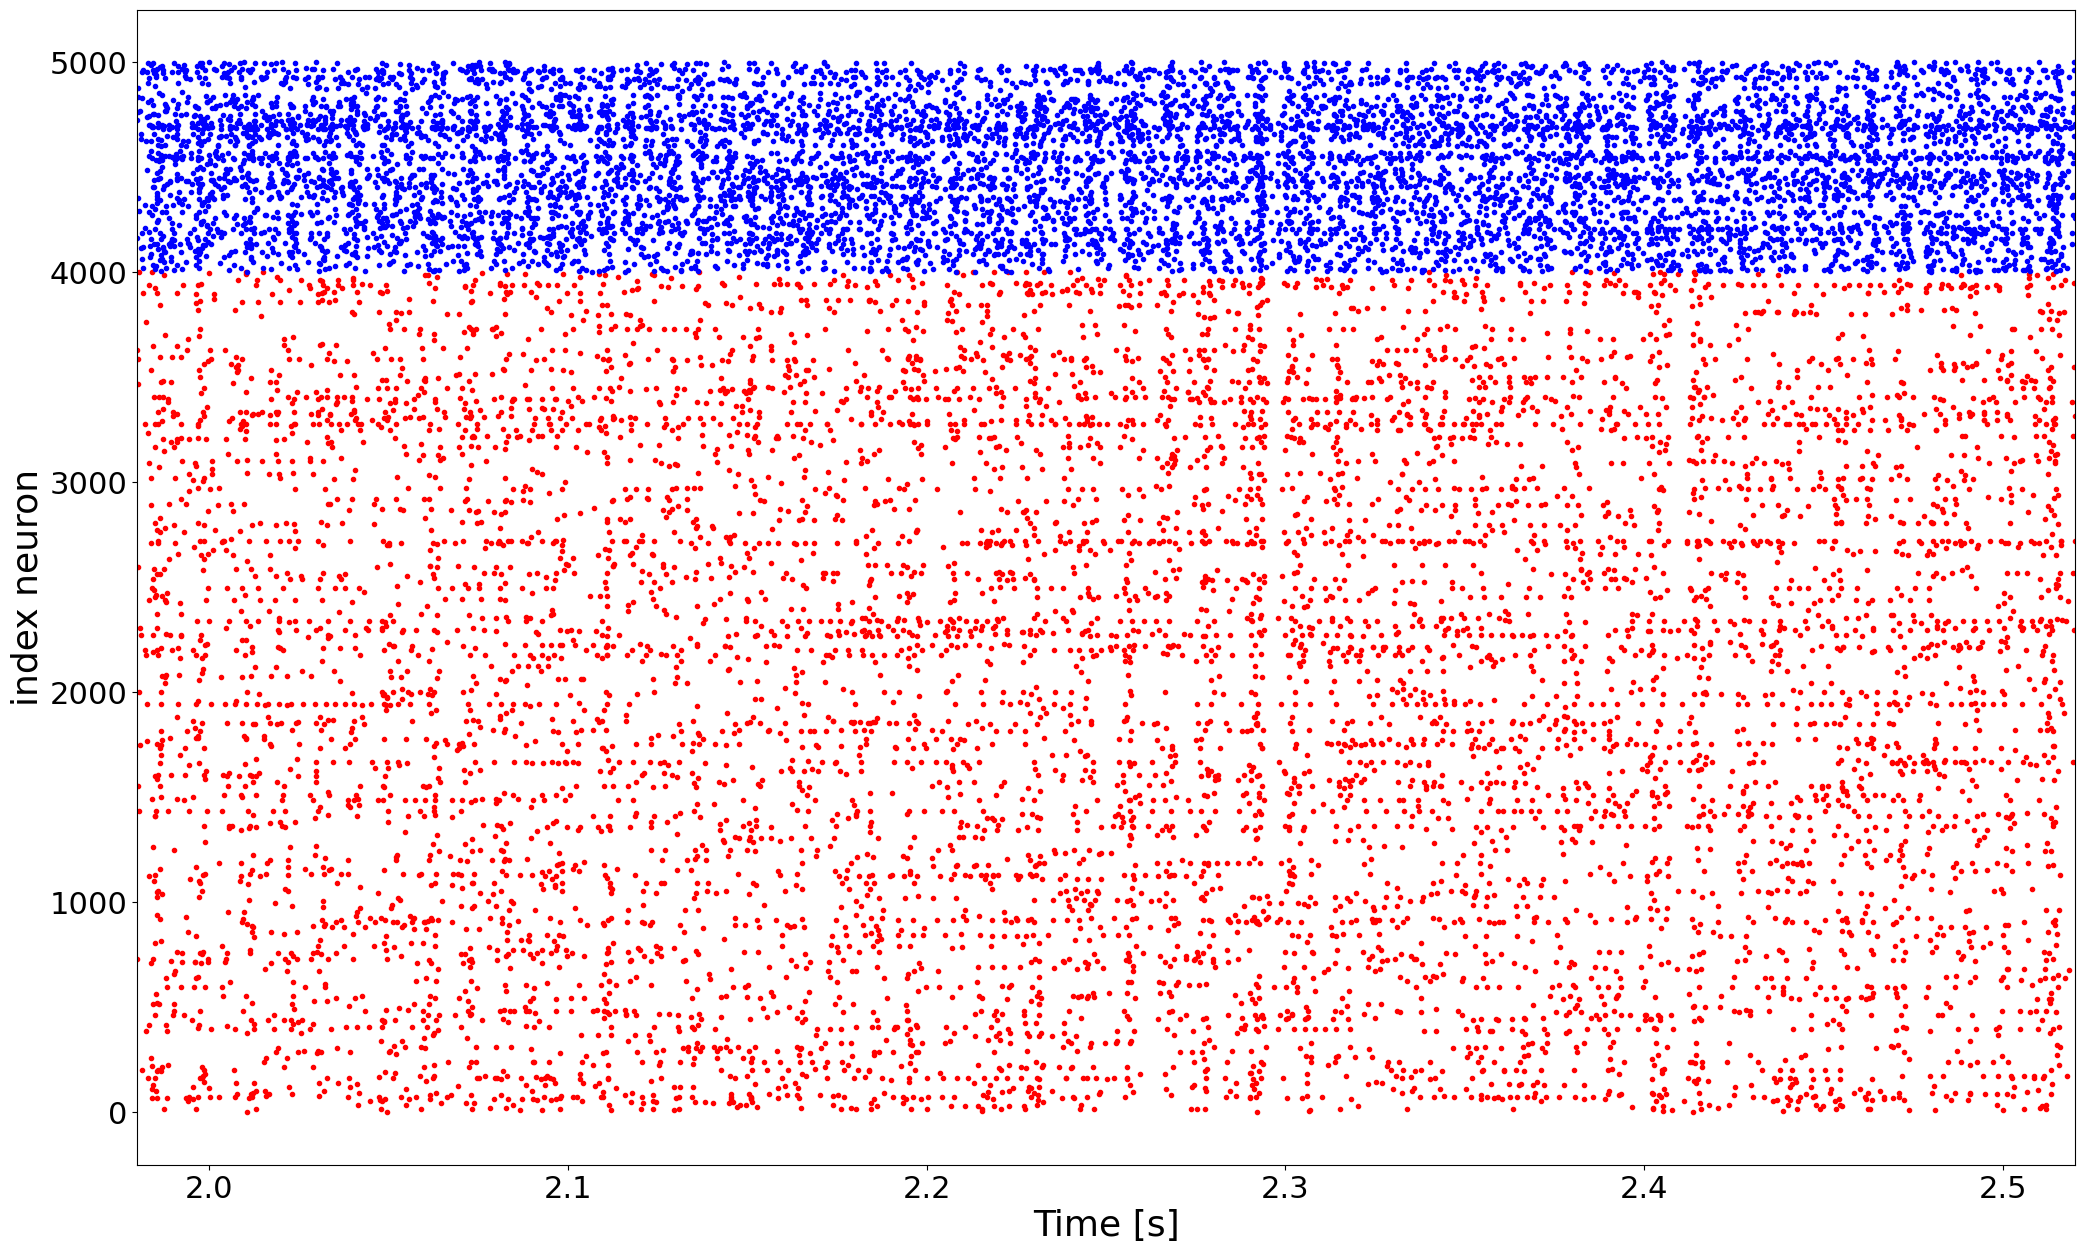

In [21]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E.t, spikes_E.i, '.', color = 'r')

# plt.plot(spikes_I.t, [spikes_I.i[kk] + 400 for kk in range(0,100)],'.', color ='b')
plt.plot(spikes_I.t, spikes_I.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(1.98, 2.52)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [11]:
E_self = []
for i,j in zip(S_E_E.i, S_E_E.j):
    if i == j:
        # print(i,j)
        E_self.append(i)

In [12]:
I_self = []
for i,j in zip(S_I_I.i, S_I_I.j):
    if i == j:
        I_self.append(i)

In [13]:
E_I_self = []
I_E_self = []
for i,j in zip(S_I_E.i[:300000], S_I_E.j[:300000]):
    if i in I_self and j in E_self and (j,i) in zip(S_E_I.i[:300000], S_E_I.j[:300000]):
        print(i,j)
        print('Num of spikes neuron %s E: {}'.format(spikes_E.count[j]) % j)
        print('Num of spikes neuron %s I: {}'.format(spikes_I.count[i]) % i)
        I_E_self.append(i)
        E_I_self.append(j)

78 1435
Num of spikes neuron 1435 E: 0
Num of spikes neuron 78 I: 234
290 1437
Num of spikes neuron 1437 E: 14
Num of spikes neuron 290 I: 0
382 2902
Num of spikes neuron 2902 E: 24
Num of spikes neuron 382 I: 154
388 1303
Num of spikes neuron 1303 E: 68
Num of spikes neuron 388 I: 7
516 1437
Num of spikes neuron 1437 E: 14
Num of spikes neuron 516 I: 62
588 1435
Num of spikes neuron 1435 E: 0
Num of spikes neuron 588 I: 52
651 227
Num of spikes neuron 227 E: 1
Num of spikes neuron 651 I: 53
695 2083
Num of spikes neuron 2083 E: 10
Num of spikes neuron 695 I: 39
709 227
Num of spikes neuron 227 E: 1
Num of spikes neuron 709 I: 0
709 567
Num of spikes neuron 567 E: 8
Num of spikes neuron 709 I: 0


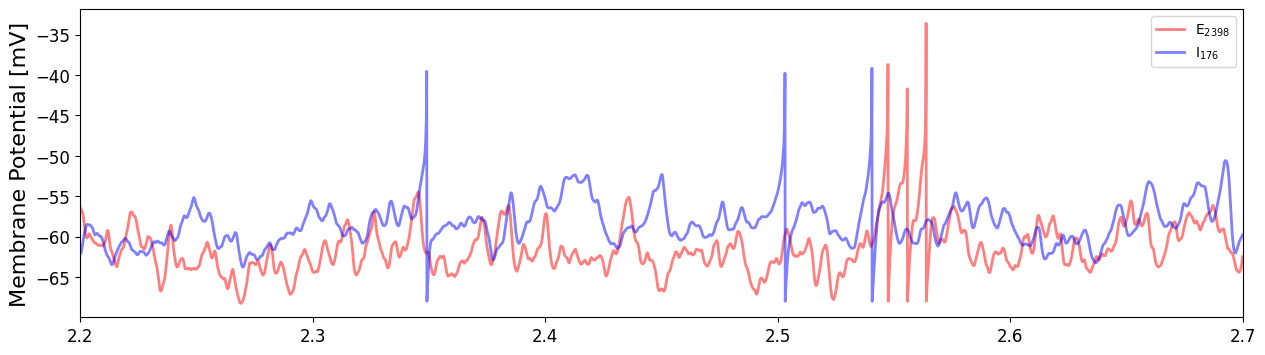

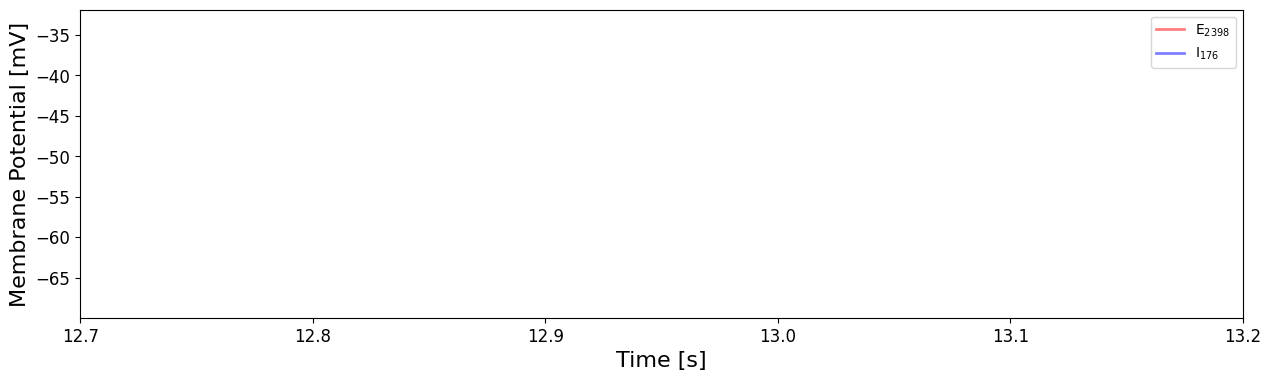

In [14]:
fig = figure(figsize=(15, 4))
for kk in [2398]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [176]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = figure(figsize=(15, 4))
for kk in [2398]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [176]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
E_I_full_spikes_EI = [(spikes_E.count[i],spikes_I.count[j]) for i, j in zip(E_I_self, I_E_self)]
print(E_I_full_spikes_EI)

[(2, 9), (6, 34), (5, 34), (20, 0), (1, 60), (24, 41), (0, 28), (0, 33), (5, 6), (6, 3), (0, 105), (7, 29), (3, 24), (49, 24), (0, 23), (0, 140), (7, 13), (49, 145), (7, 21), (2, 36), (57, 1), (6, 8), (5, 112), (10, 25), (57, 137), (30, 5), (0, 5), (5, 5), (0, 7)]


In [14]:
E_I_full_EI = [(i,j) for i, j in zip(E_I_self, I_E_self)]
print(E_I_full_EI)

[(439, 121), (254, 133), (2223, 133), (1737, 181), (2564, 203), (552, 217), (985, 245), (3447, 343), (3577, 357), (254, 462), (2918, 505), (3373, 557), (1596, 560), (3727, 560), (3447, 594), (3176, 708), (3373, 711), (3727, 780), (3373, 806), (3774, 808), (3597, 837), (254, 845), (1388, 910), (79, 938), (3597, 956), (1500, 981), (3176, 981), (3577, 981), (3176, 990)]


In [ ]:
spikes_I_data_before = spikes_I.get_states(['t', 'i'], units=False, format='pandas')
spikes_I_data_before.to_csv('spikes_I_EI_before.csv', index=False)

Num of spikes neuron 2418 E: 15
Num of spikes neuron 206 I: 0


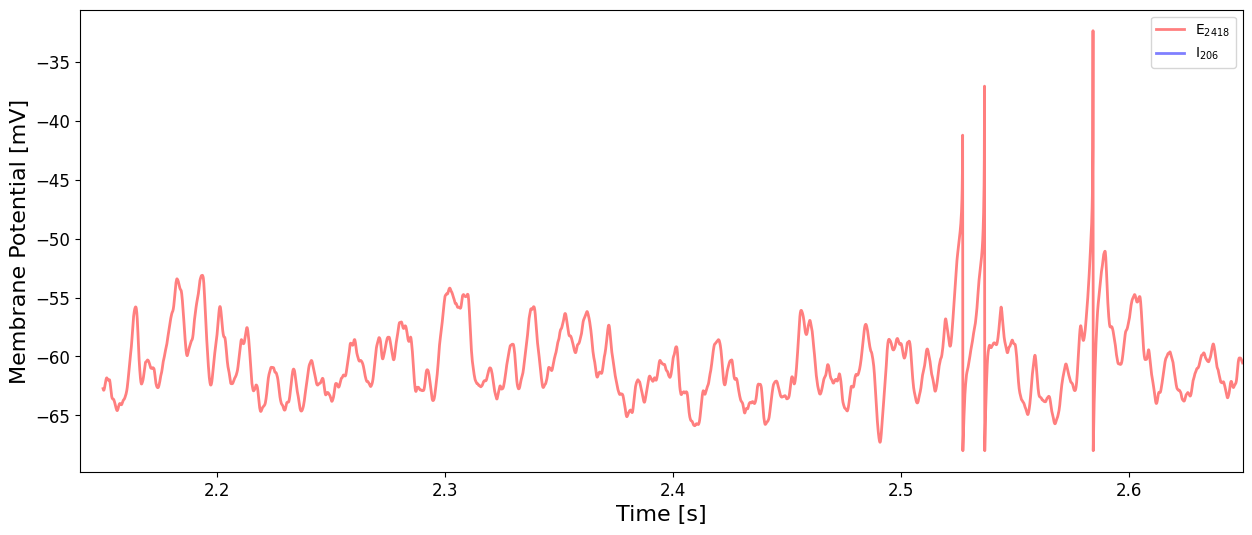

In [10]:
fig = figure(figsize=(15, 6))
for kk in [2418]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [206]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.14,2.65)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [37]:
max(rate_E.rate)

30. * hertz

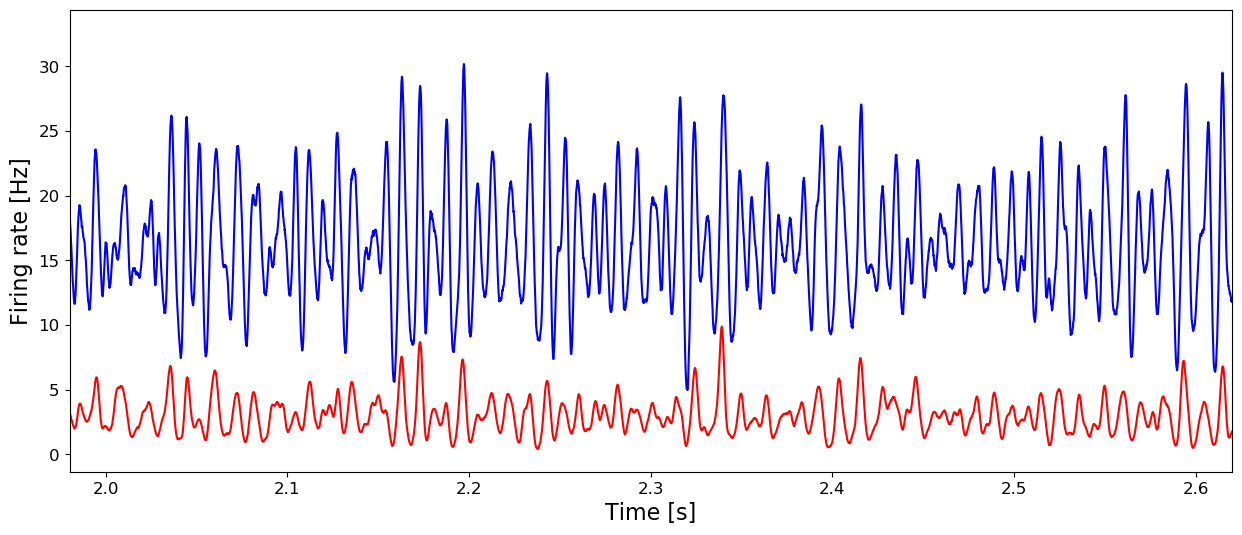

In [9]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'r')
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'b')
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
# ylim(-2,45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
print('Mean firing rate I =', np.mean(rate_I.rate), 'Hz')
print('Mean firing rate E =', np.mean(rate_E.rate), 'Hz')

Mean firing rate I = 16.336 Hz
Mean firing rate E = 3.0022 Hz


In [11]:
spikes_E_after = SpikeMonitor(E)
spikes_I_after = SpikeMonitor(I)
rate_E_after = PopulationRateMonitor(E)
rate_I_after = PopulationRateMonitor(I)

In [ ]:
# S_E_I = Synapses(E, I, model=Syn_model, on_pre=Pre_eq, on_post=Post_eq)
# S_I_E = Synapses(I, E, model=Syn_model_I, on_pre=Pre_eq_I, on_post=Post_eq_I)
# S_I_I = Synapses(I, I, model=Syn_model_I, on_pre=Pre_eq_I, on_post=Post_eq_I)
S_E_I.plastic = 1
S_E_I.notplastic = 0
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = False
spikes_I_after.active = False
rate_E.active = False
rate_I.active = False
rate_E_after.active = False
rate_I_after.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_E_I.active = False
# W_evolution_E_I.active = True
run(8000*msecond, report='text')

state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = True
spikes_I_after.active = True
rate_E.active = False
rate_I.active = False
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_E_I.active = True
run(2000*msecond, report='text')


state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E_after.active = True
spikes_I_after.active = True
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_E_I.active = True
run(500*msecond, report='text')


Starting simulation at t=2.7 s for a duration of 8. s


1.3349 s (16%) simulated in 10s, estimated 50s remaining.
2.6667 s (33%) simulated in 20s, estimated 40s remaining.
3.9996 s (49%) simulated in 30s, estimated 30s remaining.
5.3303 s (66%) simulated in 40s, estimated 20s remaining.
6.6622 s (83%) simulated in 50s, estimated 10s remaining.
7.9862 s (99%) simulated in 1m 0s, estimated < 1s remaining.
8. s (100%) simulated in 1m 0s
Starting simulation at t=10.7 s for a duration of 2. s
1.1816 s (59%) simulated in 10s, estimated 7s remaining.
2. s (100%) simulated in 16s
Starting simulation at t=12.7 s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


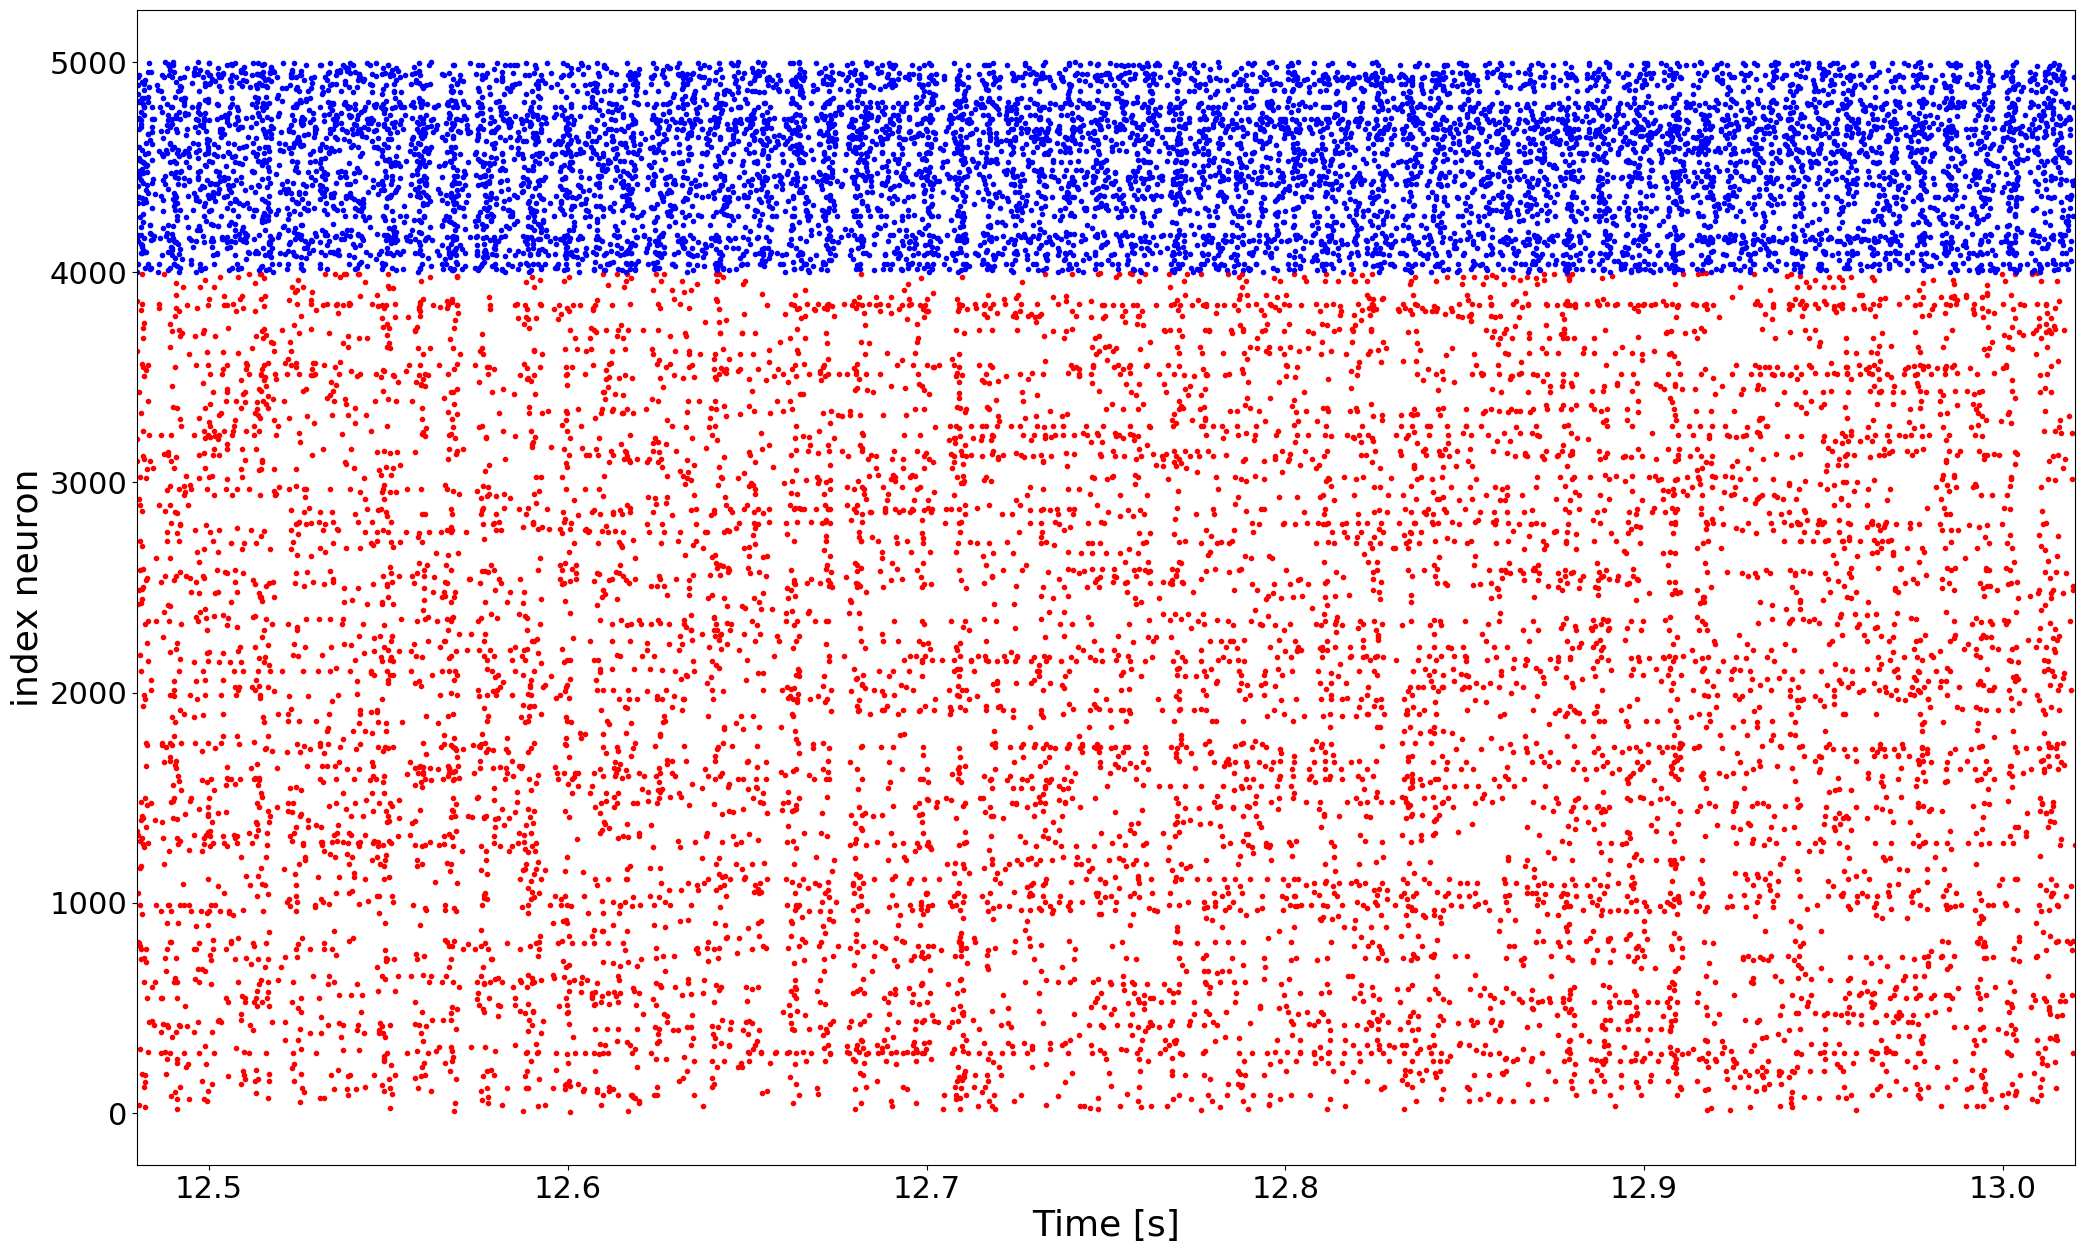

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E_after.t, spikes_E_after.i, '.', color = 'r')

plt.plot(spikes_I_after.t, spikes_I_after.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(12.48, 13.02)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

Num of spikes neuron 2418 E: 15
Num of spikes neuron 206 I: 0


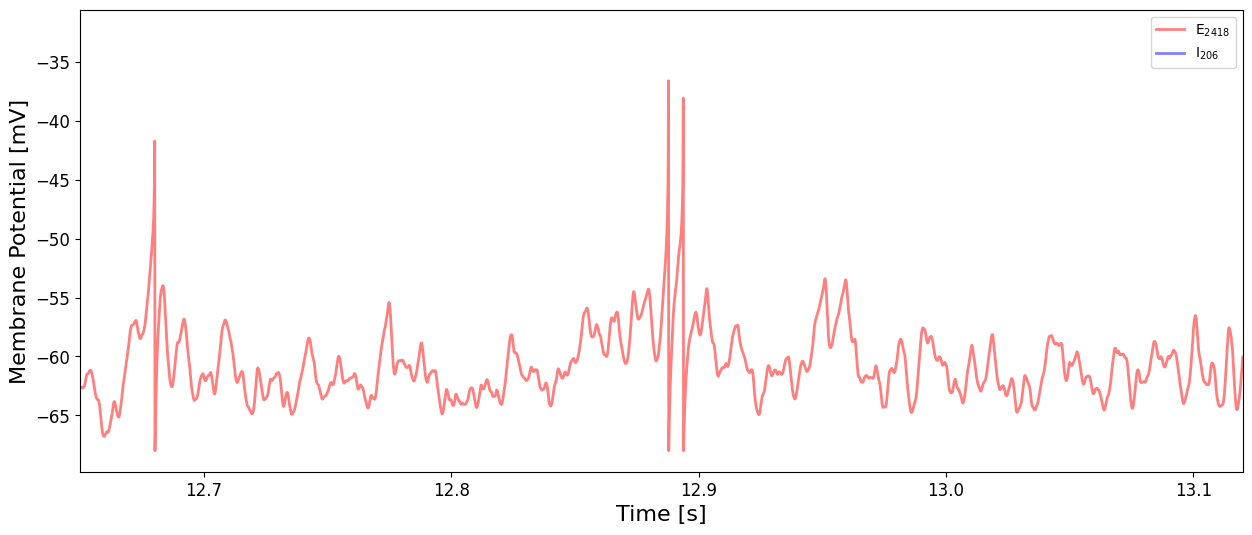

In [16]:
fig = figure(figsize=(15, 6))
for kk in [2418]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [206]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.65,13.12)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

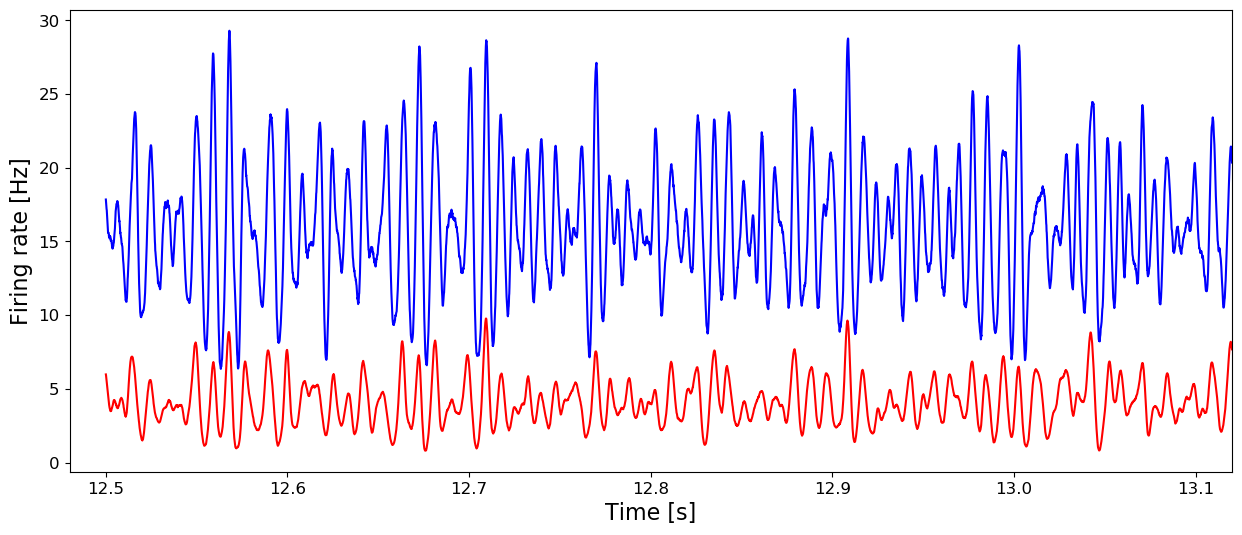

In [14]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E_after.t[18000:], rate_E_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'r')
plt.plot(rate_I_after.t[18000:], rate_I_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'b')
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(12.48, 13.12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
print('Mean firing rate =', np.mean(rate_I_after.rate), 'Hz')
print('Mean firing rate =', np.mean(rate_E_after.rate), 'Hz')

Mean firing rate = 15.9848 Hz
Mean firing rate = 4.0945 Hz


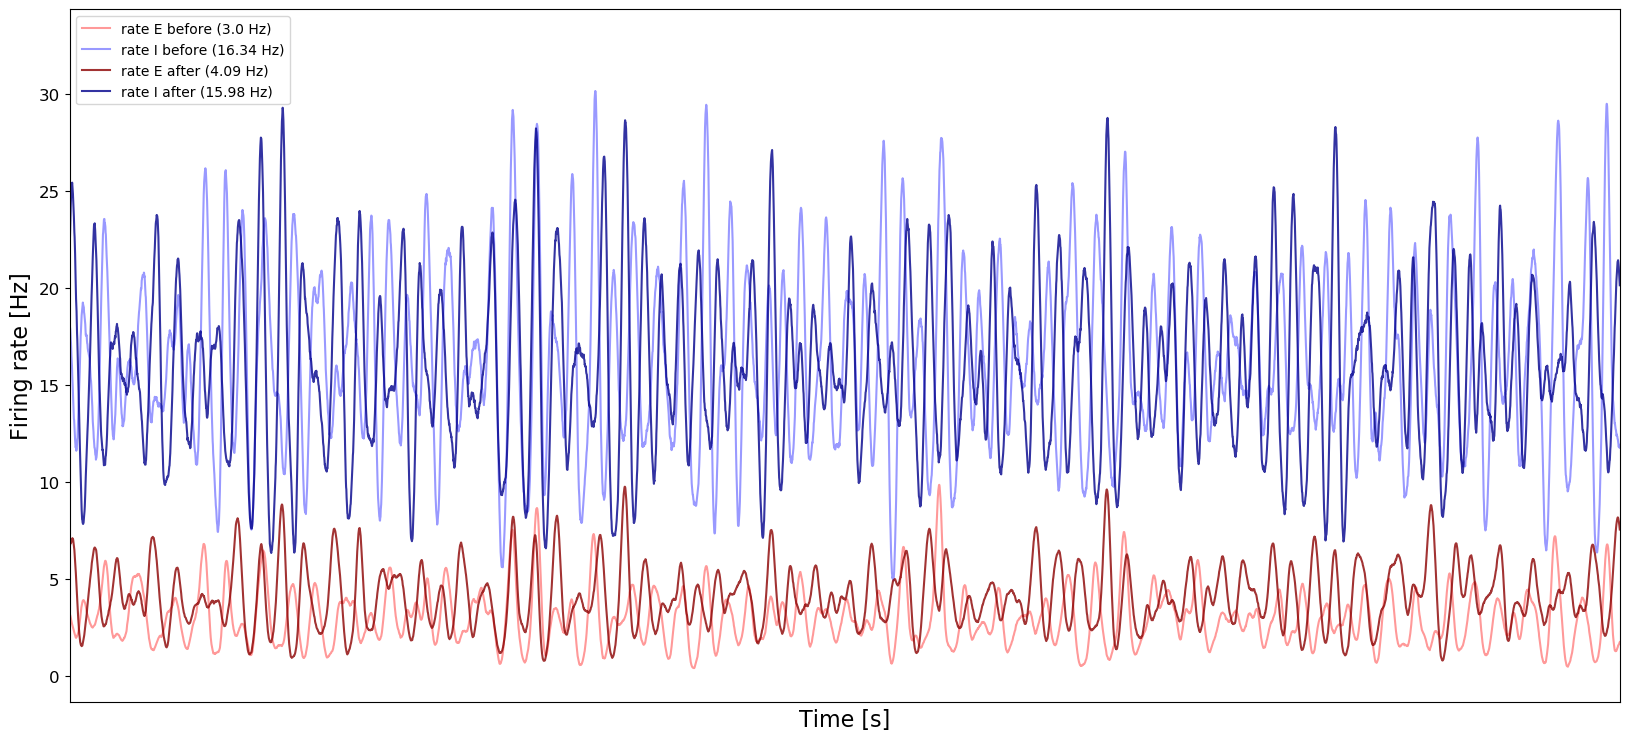

In [16]:
fig = figure(figsize=(20, 9))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'red', alpha = 0.4, label = 'rate E before (%s Hz)'  % np.round(np.mean(rate_E.rate),2))
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'blue', alpha = 0.4, label = 'rate I before (%s Hz)'  % np.round(np.mean(rate_I.rate),2))
plt.plot(rate_E.t, rate_E_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkred', alpha = 0.8, label = 'rate E after (%s Hz)'  % np.round(np.mean(rate_E_after.rate),2))
plt.plot(rate_I.t, rate_I_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkblue', alpha = 0.8, label = 'rate I after (%s Hz)'  % np.round(np.mean(rate_I_after.rate),2))
plt.legend()
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
# ylim(-2,45)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [18]:
import seaborn as sns
spikes_I_neur = list(spikes_I.i)
my_dict_I = {i:spikes_I_neur.count(i)/2.5 for i in range(1000)}
my_dict_I = dict(sorted(my_dict_I.items()))
spikes_I_neur_after = list(spikes_I_after.i)
my_dict_after_I = {i:spikes_I_neur_after.count(i)/2.5 for i in range(1000)}
my_dict_after_I = dict(sorted(my_dict_after_I.items()))


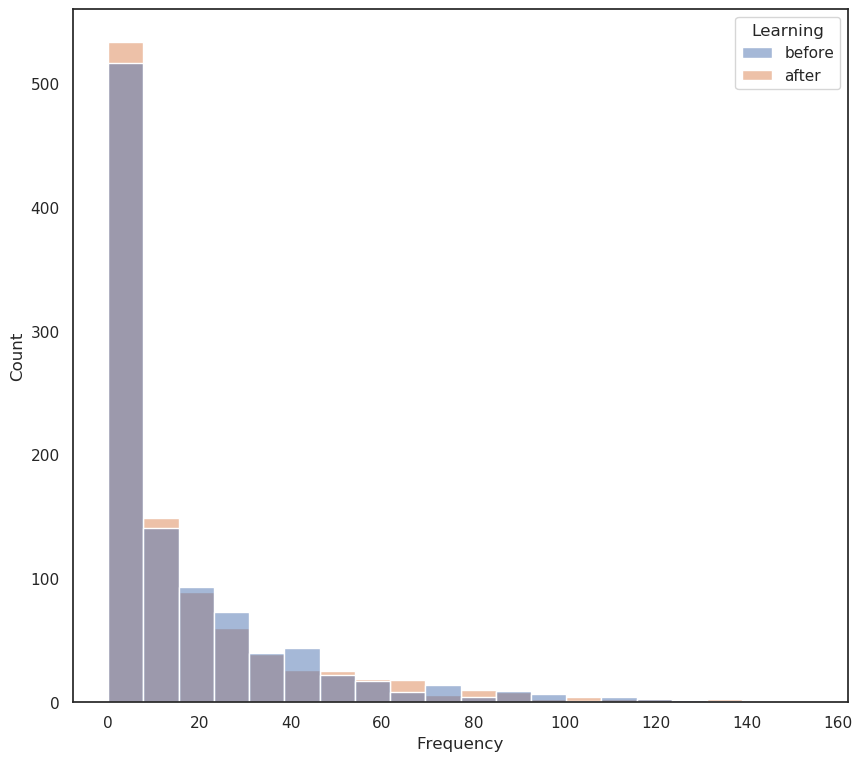

In [ ]:
sns.set_theme(style='white')
stdp = ['before']*len(list(my_dict_I.values())) + ['after']*len(list(my_dict_after_I.values()))
df = pd.DataFrame({"Frequency": list(my_dict_I.values()) + list(my_dict_after_I.values()), "Neuron indx": list(my_dict_I.keys()) + list(my_dict_after_I.keys()), "Learning": stdp})

fig, ax1 = plt.subplots(figsize=(10, 9))
sns.histplot(data=df, x="Frequency", discrete=False, ax=ax1, bins = 20, alpha = 0.5, hue = "Learning")



In [ ]:
delta_f = 1/2.5 * Hz
T_init = 60 * ms
k = 1024
T_signal = 2500 *ms
T_sim = k * T_signal + T_init
data = rate_I.rate/b2.Hz
delta_t = rate_I.clock.dt
f_max = 1./(2. * delta_t)
N_signal = int(2 * f_max / delta_f)
T_signal = N_signal * delta_t
N_init = 0
N_required = k * N_signal + N_init
N_data = len(data)



1000 2500.5
mean_firing_rate:0.0
59
130


(<Figure size 640x480 with 1 Axes>, [59, 130])

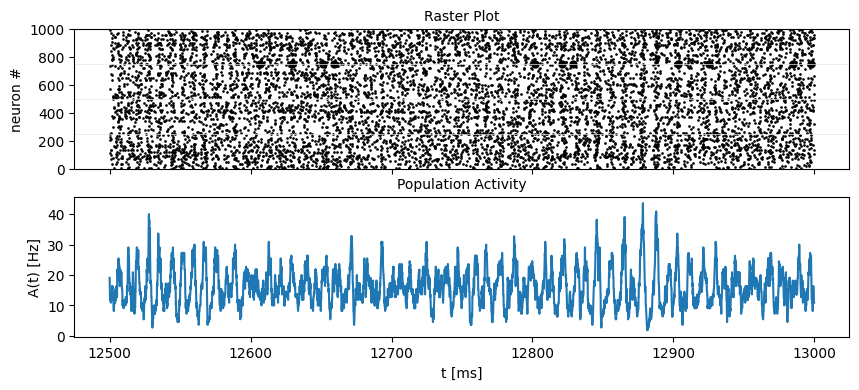

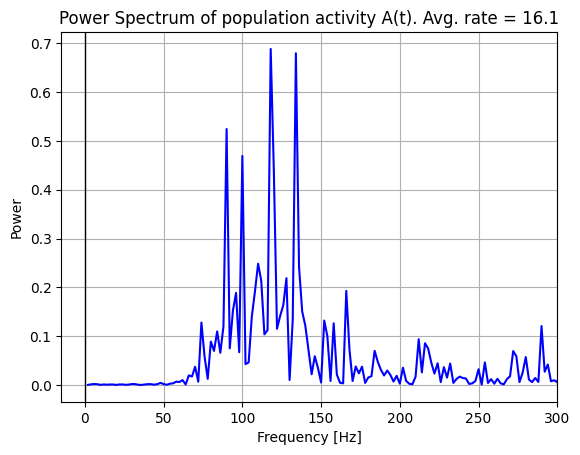

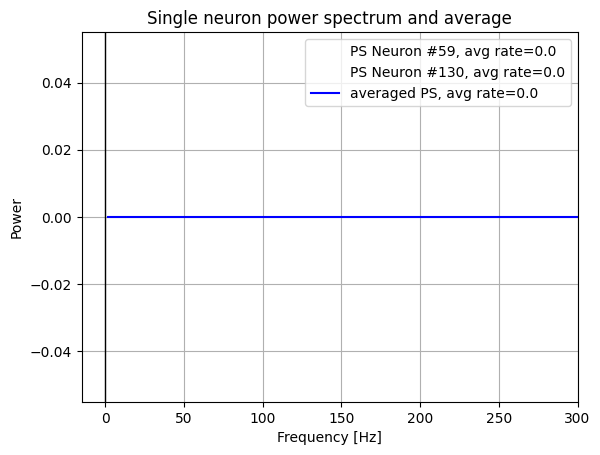

In [30]:
plot_tools.plot_network_activity(rate_I, spikes_I, t_min = 12500 *ms, spike_train_idx_list=list(range(1000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_I, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 1000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=2)

4000 2500.5
mean_firing_rate:0.0
713
2143
3124


(<Figure size 640x480 with 1 Axes>, [713, 2143, 3124])

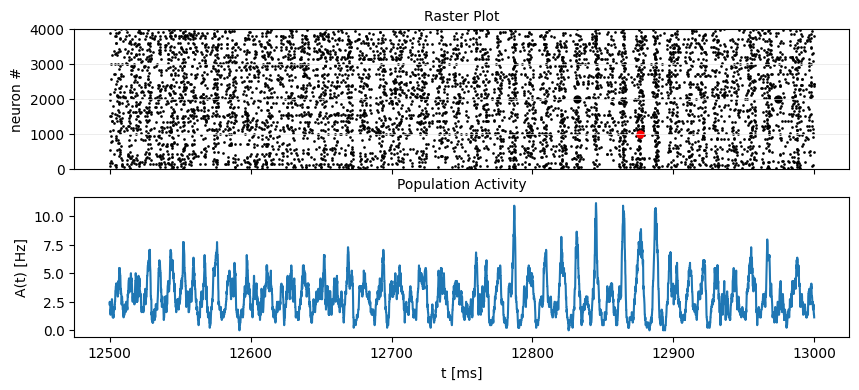

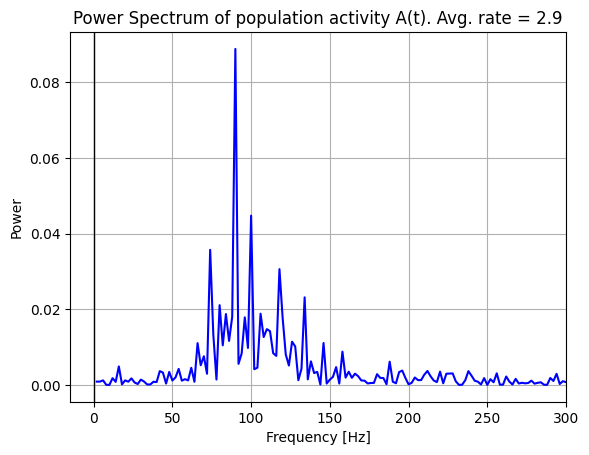

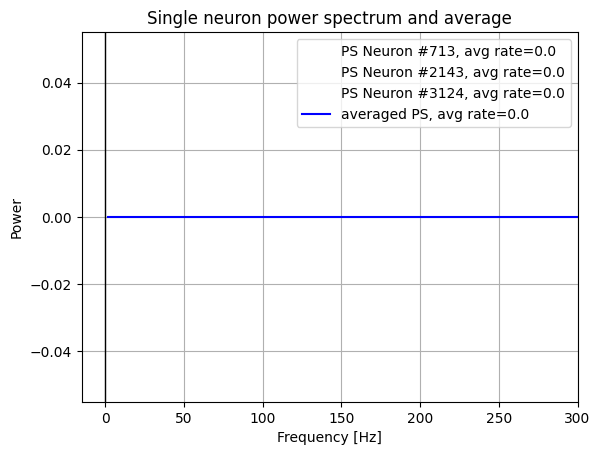

In [31]:
plot_tools.plot_network_activity(rate_E, spikes_E, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)

4000 2500.5
mean_firing_rate:0.0
1051
231
1531


(<Figure size 640x480 with 1 Axes>, [1051, 231, 1531])

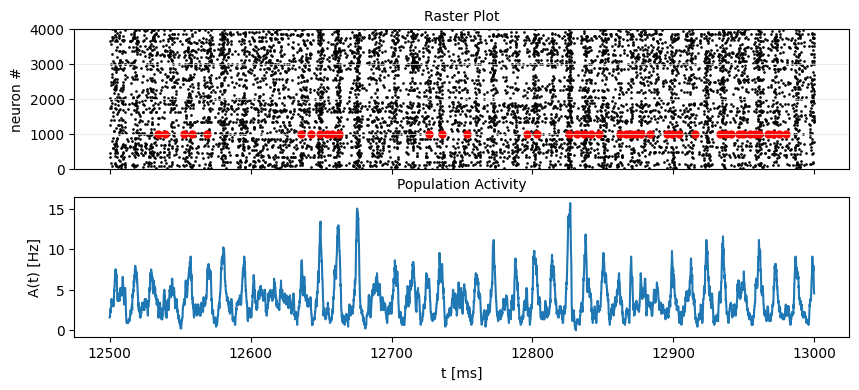

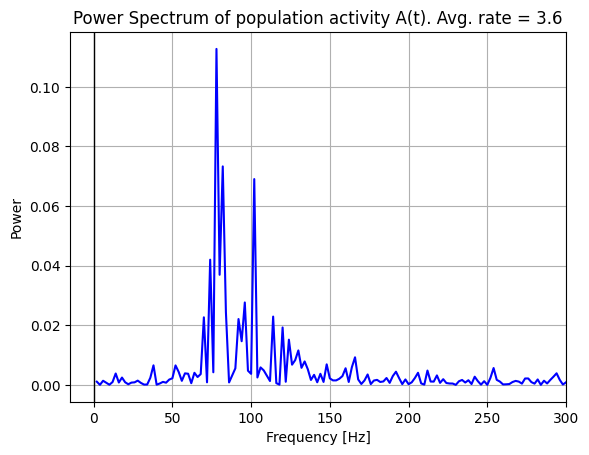

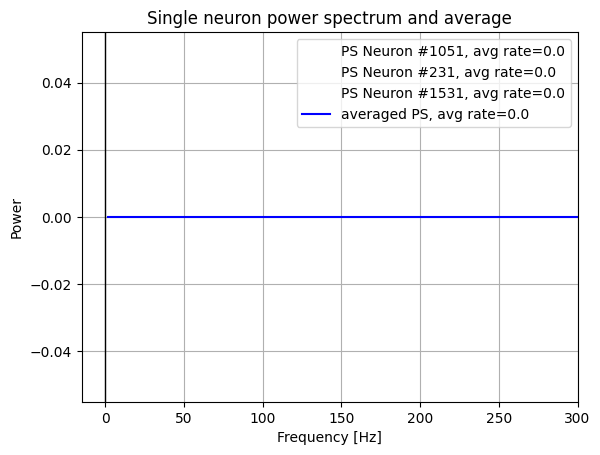

In [58]:
plot_tools.plot_network_activity(rate_E_after, spikes_E_after, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E_after, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E_after, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)